read data and search israel in country


In [ ]:
import pandas as pd

# Attempting to read with 'ISO-8859-1' encoding, which is common for non-UTF-8 encoded files
df = pd.read_csv('/content/IL_data.csv', encoding='ISO-8859-1')
df.head()


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197109160001,1971,9,16,NaN,0,NaN,97,Israel,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
1,197205300001,1972,5,30,NaN,0,NaN,97,Israel,10,...,NaN,NaN,NaN,NaN,PGIS,1,1,0,1,NaN
2,197209200003,1972,9,20,NaN,0,NaN,97,Israel,10,...,NaN,http://news.bbc.co.uk/onthisday/hi/dates/stori...,"""26 more bombs sent to Israelis here, abroad,""...","""5 more leter bombs in Brussels, Kinshasa,"" Th...",UMD Miscellaneous,1,1,0,1,"197209190001, 197209190002, 197209190003, 1972..."
3,197209200004,1972,9,20,NaN,0,NaN,97,Israel,10,...,NaN,http://news.bbc.co.uk/onthisday/hi/dates/stori...,"""26 more bombs sent to Israelis here, abroad,""...","""5 more leter bombs in Brussels, Kinshasa,"" Th...",UMD Miscellaneous,1,1,0,1,"197209190001, 197209190002, 197209190003, 1972..."
4,197209200005,1972,9,20,NaN,0,NaN,97,Israel,10,...,NaN,http://news.bbc.co.uk/onthisday/hi/dates/stori...,"""26 more bombs sent to Israelis here, abroad,""...","""5 more leter bombs in Brussels, Kinshasa,"" Th...",UMD Miscellaneous,1,1,0,1,"197209190001, 197209190002, 197209190003, 1972..."


In [ ]:
!pip install pandas matplotlib seaborn geopandas

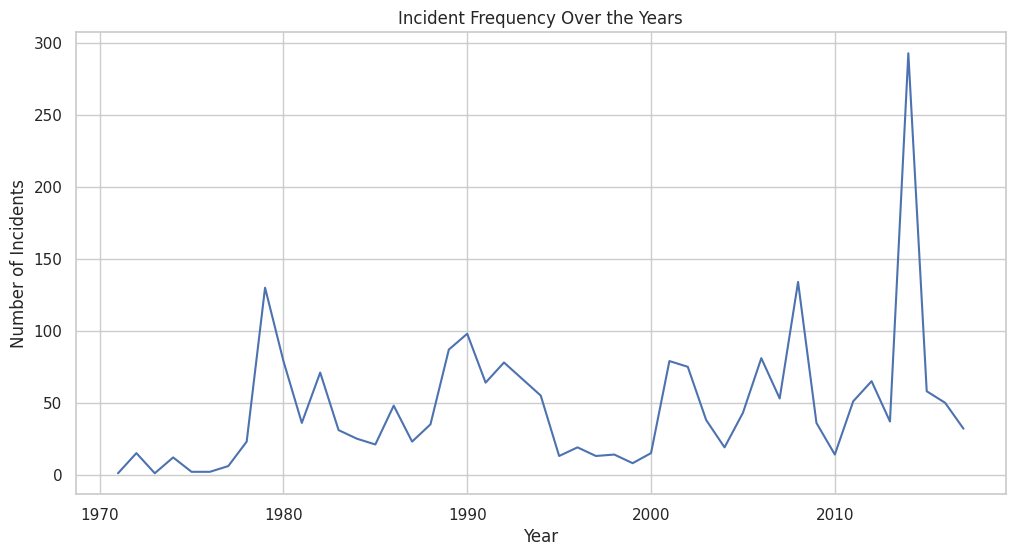

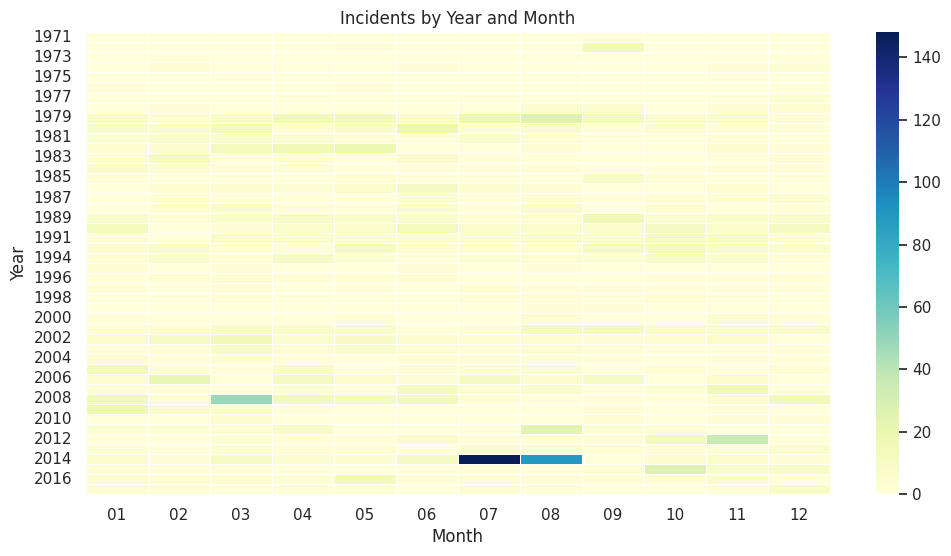

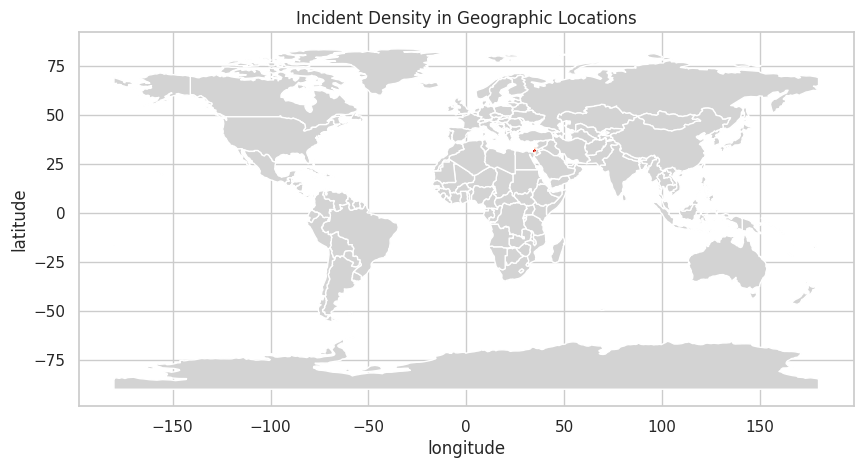

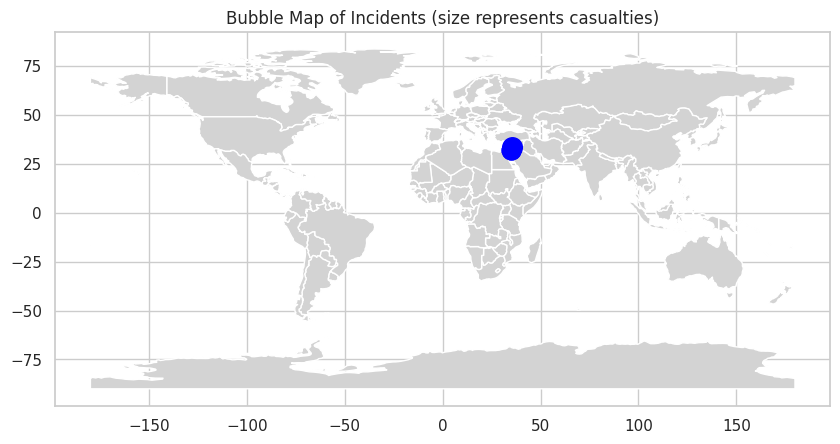

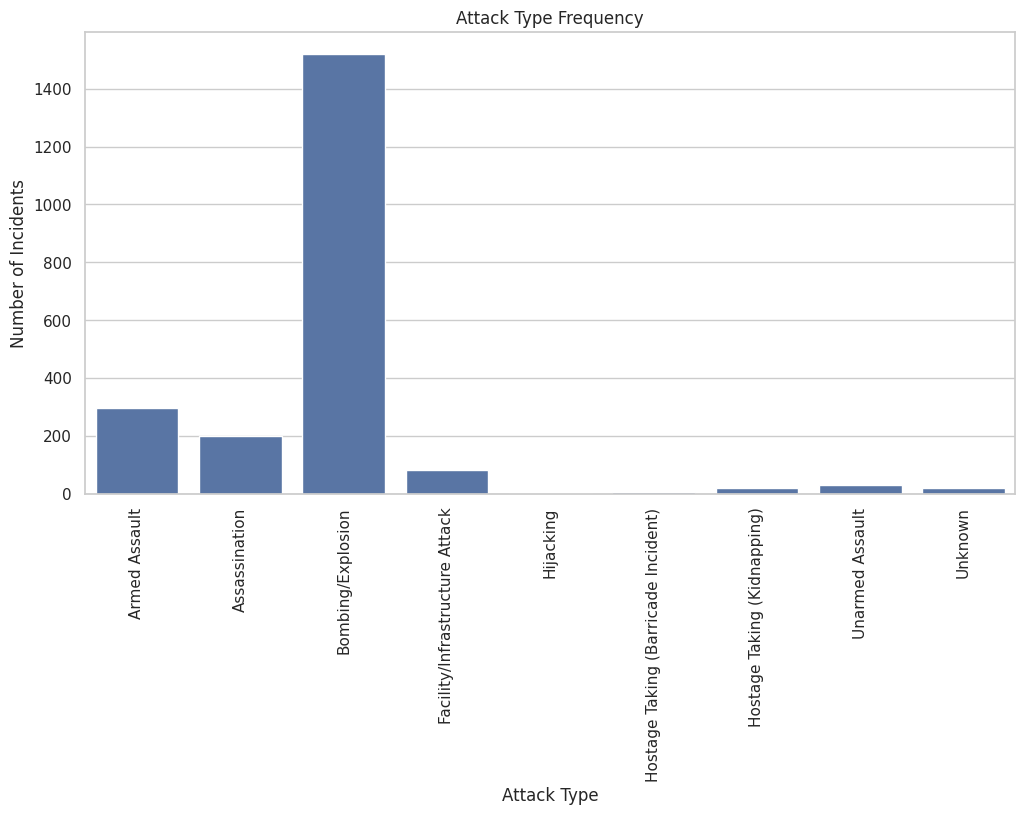

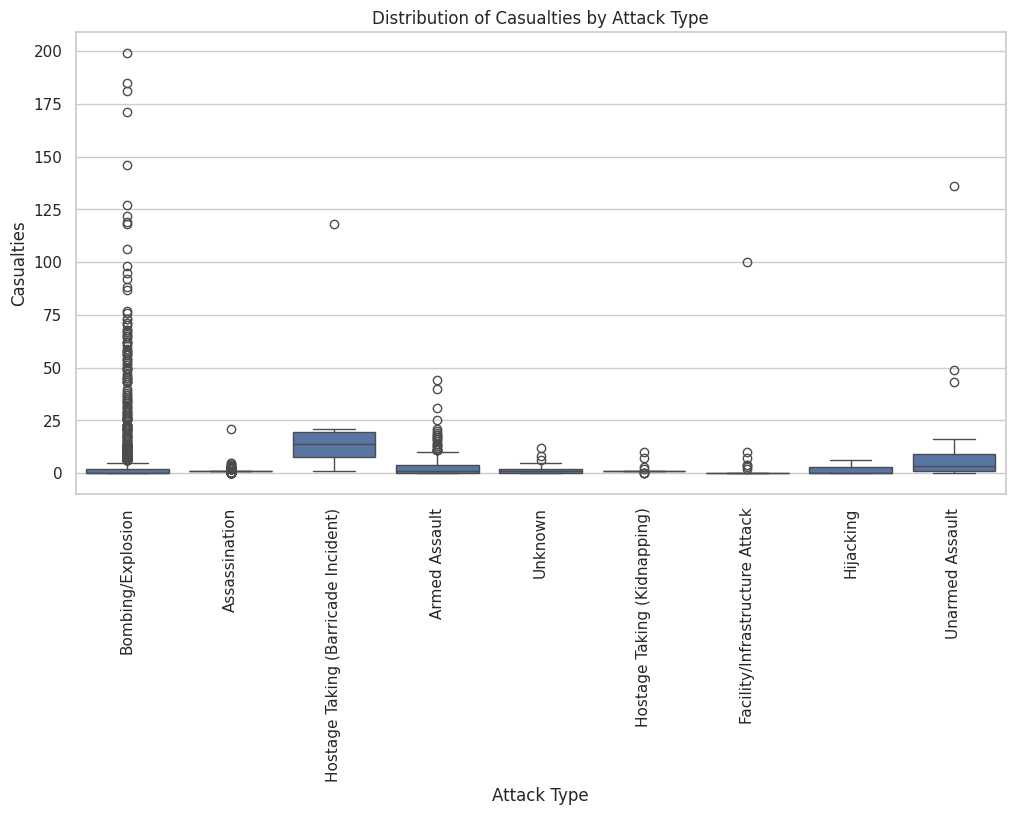

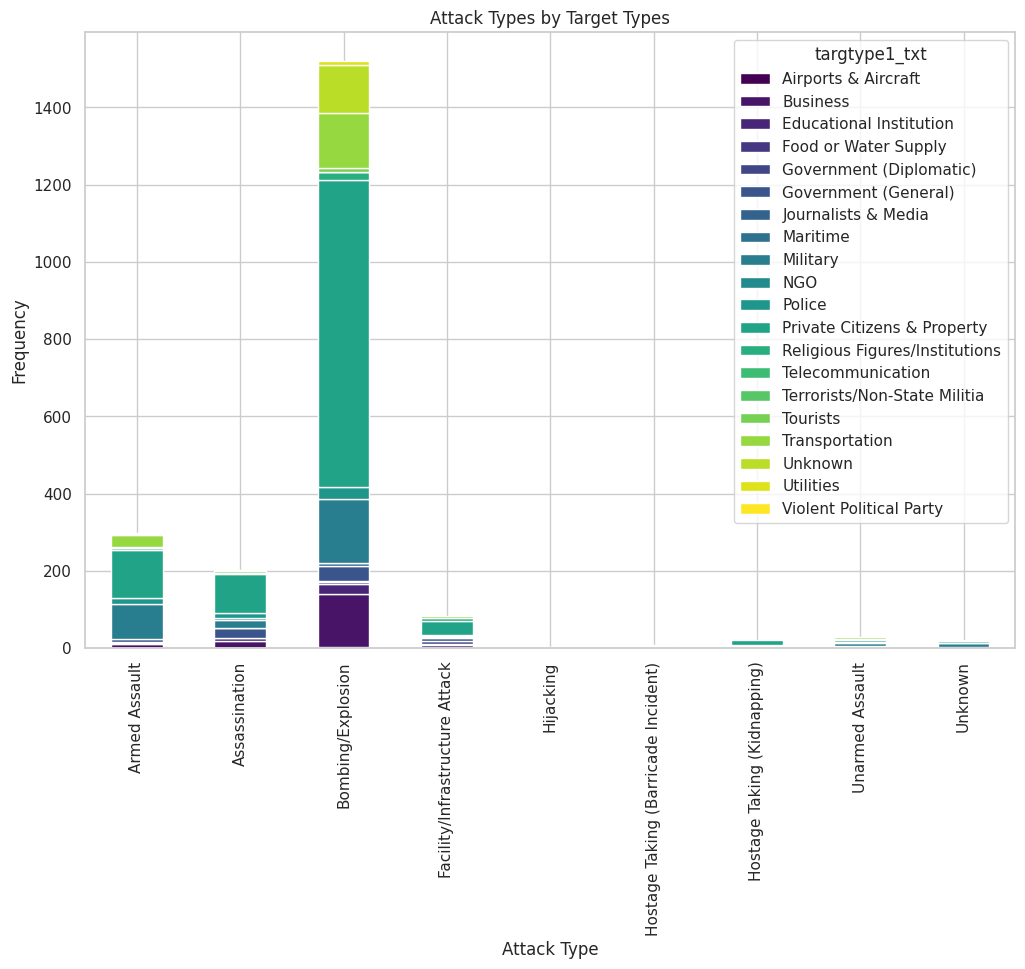

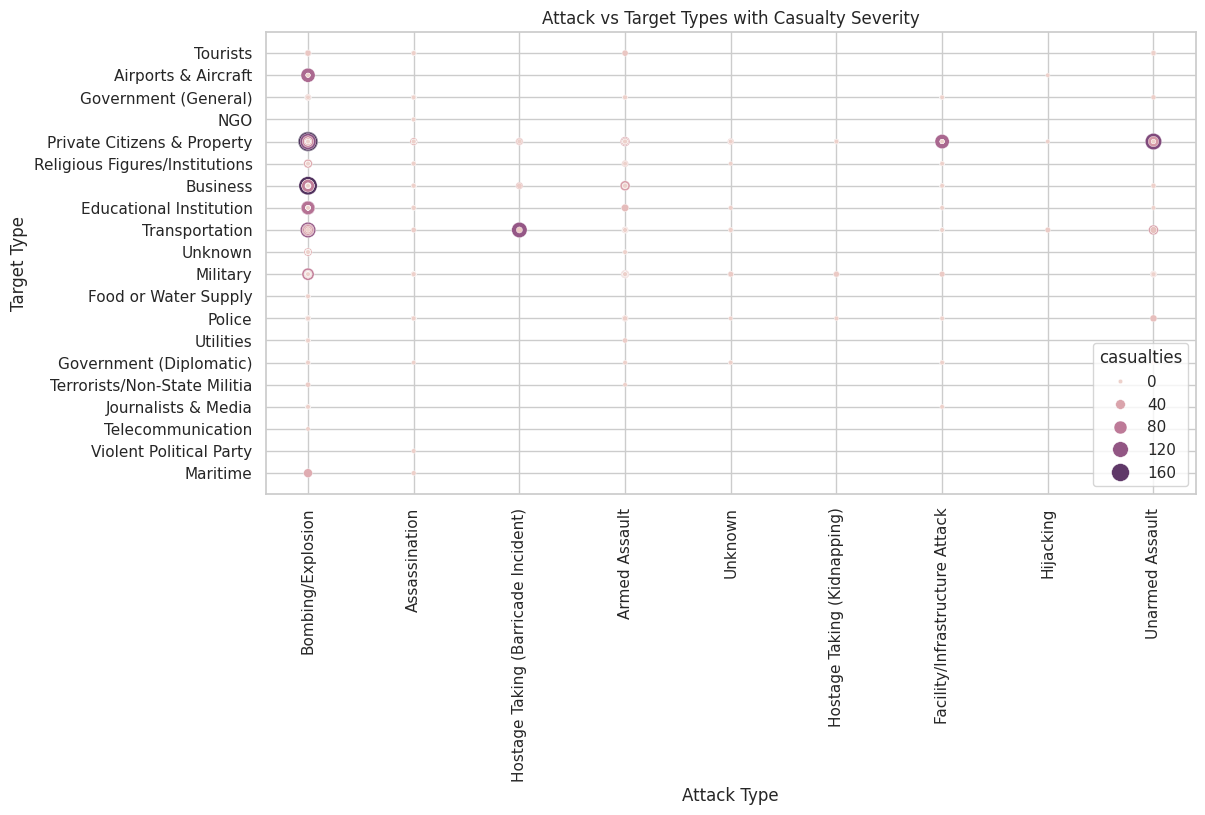

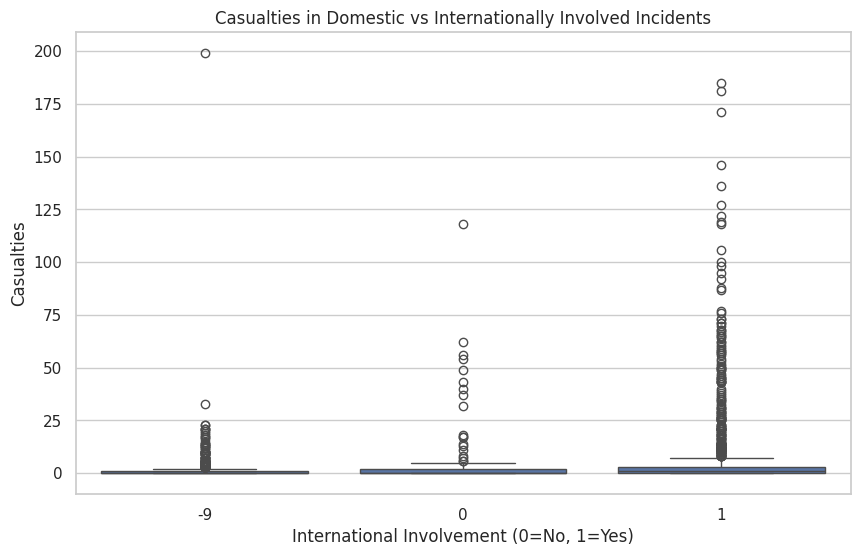

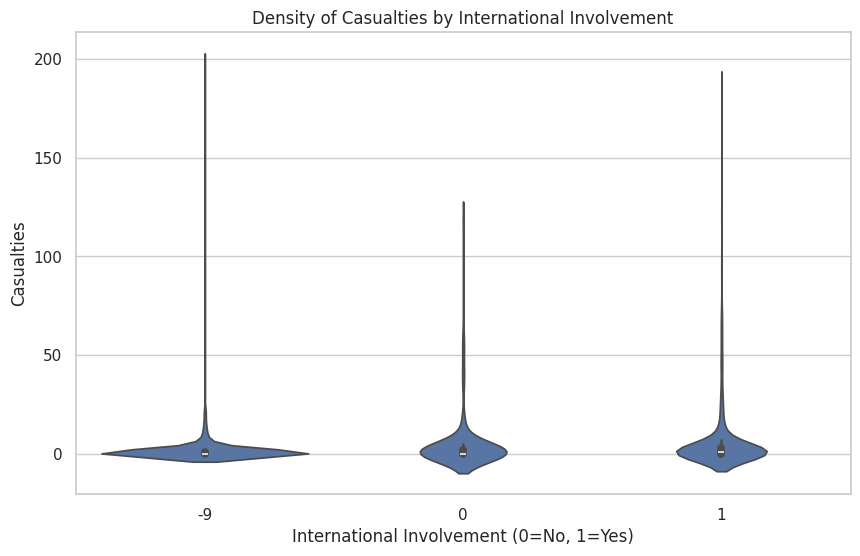

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the dataset
df = pd.read_csv('/content/IL_data.csv', encoding='ISO-8859-1')

# Fill missing month and day values with a default (January 1st) to handle missing dates
df['iyear'] = df['iyear'].fillna(0).astype(int)  # If any year is missing, fill with zero or an appropriate value
df['imonth'] = df['imonth'].fillna(1).astype(int)  # Fill missing months with January (1)
df['iday'] = df['iday'].fillna(1).astype(int)      # Fill missing days with 1

# Convert to a single datetime column
# The original code used incorrect column names. Rename the columns to 'year', 'month', 'day' for pd.to_datetime
df['date'] = pd.to_datetime(df[['iyear', 'imonth', 'iday']].rename(columns={'iyear': 'year', 'imonth': 'month', 'iday': 'day'}), errors='coerce')

# Set visual style
sns.set(style='whitegrid')

### Visualization 1: Frequency and Severity of Incidents Over the Years

# Group by year and calculate incident count and severity (e.g., average casualties)
df['casualties'] = df[['nkill', 'nwound']].sum(axis=1)
yearly_data = df.groupby('iyear').agg({'eventid': 'count', 'casualties': 'sum'}).reset_index()

# Line Chart - Incident frequency over years
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_data, x='iyear', y='eventid', color='b')
plt.title('Incident Frequency Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()

# Heatmap - Incidents by Year and Month
df['imonth'] = df['imonth'].apply(lambda x: f"{x:02d}")
heatmap_data = df.groupby(['iyear', 'imonth']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Incidents by Year and Month')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

### Visualization 2: Geographic Distribution of Incidents

# Load world boundaries for map plot
# Instead of using gpd.datasets.get_path, download the data and load it directly:
!wget https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip ne_110m_admin_0_countries.zip
world = gpd.read_file("ne_110m_admin_0_countries.shp") # Load the shapefile
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)) # Assuming 'longitude' and 'latitude' columns exist in your DataFrame

# Density Map
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color='lightgrey')
sns.kdeplot(data=gdf, x="longitude", y="latitude", cmap="Reds", fill=True, ax=ax)  # Changed shade=True to fill=True
plt.title("Incident Density in Geographic Locations")
plt.show()

# Bubble Map
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='blue', markersize=df['casualties'].fillna(1)) # Now 'gdf' is defined
plt.title("Bubble Map of Incidents (size represents casualties)")
plt.show()

### Visualization 3: Attack Type and Impact on Casualties

# Bar Chart - Attack type frequency and severity
attack_data = df.groupby('attacktype1_txt').agg({'eventid': 'count', 'casualties': 'mean'}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=attack_data, x='attacktype1_txt', y='eventid', color='b')
plt.title('Attack Type Frequency')
plt.xlabel('Attack Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90)
plt.show()

# Box Plot - Attack type by casualties distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='attacktype1_txt', y='casualties')
plt.title('Distribution of Casualties by Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Casualties')
plt.xticks(rotation=90)
plt.show()

### Visualization 4: Correlation Between Attack and Target Type

# Stacked Bar Chart - Attack vs Target type frequency
attack_target = df.groupby(['attacktype1_txt', 'targtype1_txt']).size().unstack(fill_value=0)
attack_target.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Attack Types by Target Types')
plt.xlabel('Attack Type')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

# Scatter Plot with Size Encoding - Attack type, target type, and severity
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='attacktype1_txt', y='targtype1_txt', size='casualties', hue='casualties', sizes=(10, 200))
plt.title('Attack vs Target Types with Casualty Severity')
plt.xlabel('Attack Type')
plt.ylabel('Target Type')
plt.xticks(rotation=90)
plt.show()

### Visualization 5: Casualty Comparison Between Domestic and International Involvement

# Add columns to indicate international involvement
df['international'] = df['INT_LOG'] | df['INT_IDEO'] | df['INT_MISC'] | df['INT_ANY']

# Box Plot - Casualties with and without international involvement
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='international', y='casualties')
plt.title('Casualties in Domestic vs Internationally Involved Incidents')
plt.xlabel('International Involvement (0=No, 1=Yes)')
plt.ylabel('Casualties')
plt.show()

# Violin Plot - Density of casualties in international vs domestic incidents
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='international', y='casualties')
plt.title('Density of Casualties by International Involvement')
plt.xlabel('International Involvement (0=No, 1=Yes)')
plt.ylabel('Casualties')
plt.show()


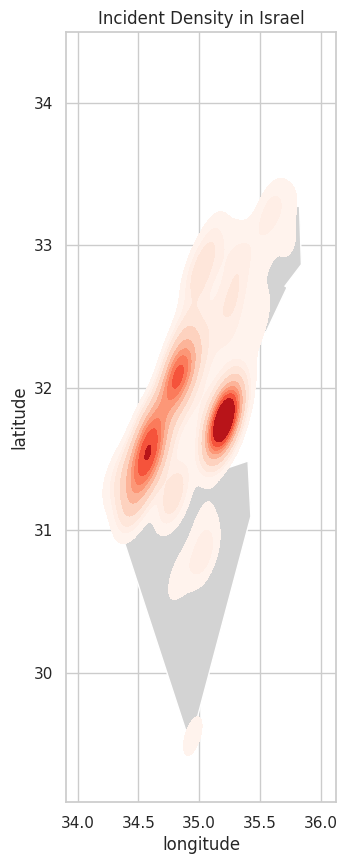

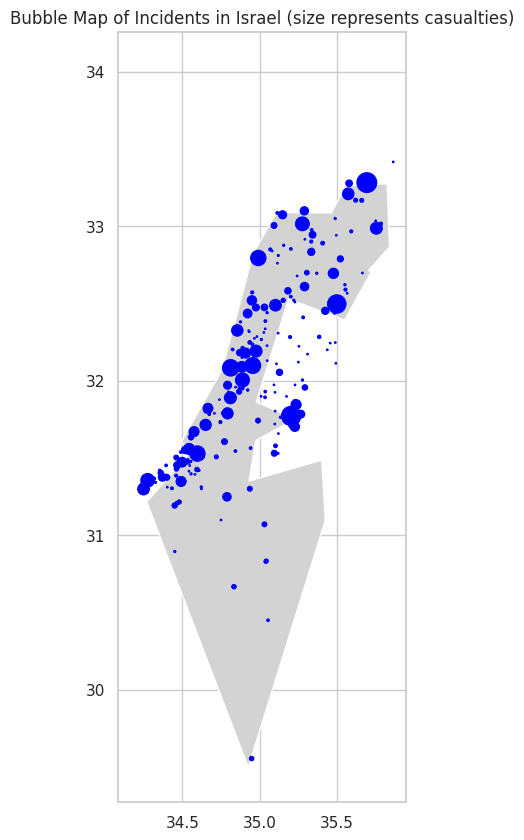

In [ ]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the shapefile for world boundaries
world = gpd.read_file("ne_110m_admin_0_countries.shp")

# Filter for Israel only
israel = world[world['NAME'] == "Israel"]

# Ensure GeoDataFrame is correctly structured with incidents in Israel
df = pd.read_csv('/content/IL_data.csv', encoding='ISO-8859-1')
df['casualties'] = df[['nkill', 'nwound']].sum(axis=1)

# Filter dataset for Israel-specific incidents, assuming 'country_txt' column exists
df_israel = df[df['country_txt'] == 'Israel']
gdf_israel = gpd.GeoDataFrame(df_israel, geometry=gpd.points_from_xy(df_israel.longitude, df_israel.latitude))

# Density Map - Focusing on Israel
fig, ax = plt.subplots(figsize=(10, 10))
israel.plot(ax=ax, color='lightgrey')
sns.kdeplot(data=gdf_israel, x="longitude", y="latitude", cmap="Reds", fill=True, ax=ax)
plt.title("Incident Density in Israel")
plt.show()

# Bubble Map - Focusing on Israel
fig, ax = plt.subplots(figsize=(10, 10))
israel.plot(ax=ax, color='lightgrey')
gdf_israel.plot(ax=ax, color='blue', markersize=df_israel['casualties'].fillna(1))
plt.title("Bubble Map of Incidents in Israel (size represents casualties)")
plt.show()
